In [7]:
import os
import sys
import numpy as np
import pandas as pd
from string import ascii_uppercase

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Circle
from sklearn.metrics import adjusted_rand_score
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

%matplotlib inline

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data, read_transcription_data, read_embedding_data
from plot import draw_start, draw_path, draw_clusters
from graph import compute_distance_matrix, compute_path_idxs, compute_clusters

In [2]:
model = 'triplet-gi-0999'
fullres = False
dz, section, start_idx, end_idx, start_label, end_label = ('CD', 'A', 2462, 524,  'left', 'bottom')

In [3]:
def draw_circles(spot_radius, pos_df, alpha):
    circs = PatchCollection(
        [Circle((x, y), spot_radius) for x, y in pos_df[["x", "y"]].to_numpy()],
        picker=True,
    )
    facecolors = np.asarray([list(to_rgba("lightgray"))] * len(pos_df))
    edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(pos_df))
    alphas = np.full(len(pos_df), alpha)
    circs.set_facecolor(facecolors)
    circs.set_edgecolor(edgecolors)
    circs.set_alpha(alphas)
    return circs, facecolors, edgecolors, alphas

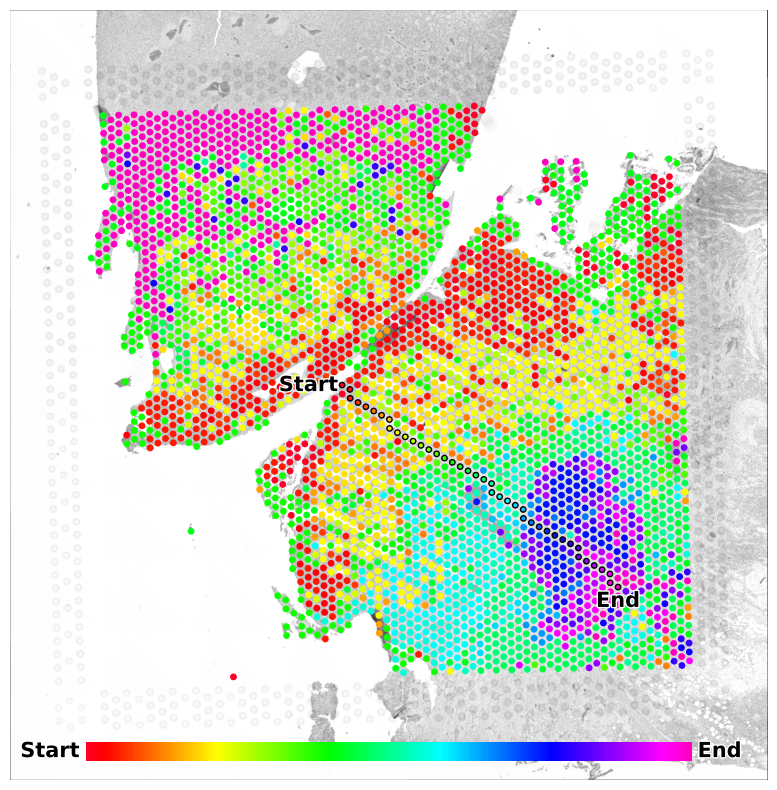

In [5]:
figsize = 8
fontsize=15
alpha = 1
nrows = 1
ncols = 1
plt.close()
fig, ax = plt.subplots(nrows, ncols, figsize=(figsize * ncols, figsize * nrows))

ax.set_axis_off()

# ATAT alignment
section_path = f'/mnt/data1/spatial/data/colon/{dz}/{section}'
im = read_image(section_path, fullres)
pos_df, spot_radius = read_spatial_data(section_path, fullres)
embeds = read_embedding_data(section_path, model)
counts = read_transcription_data(section_path)
dists, hex = compute_distance_matrix(embeds, pos_df)
path_idxs = compute_path_idxs(dists, hex, start_idx, end_idx)
clusters = compute_clusters(embeds, embeds[path_idxs])

ax.imshow(np.asarray(im.convert("L")), cmap='gray', vmin=0, vmax=255)
circs_etc = draw_circles(spot_radius, pos_df, alpha)
ax.add_collection(circs_etc[0])
fig.tight_layout()
circs, facecolors, edgecolors, alphas = circs_etc
draw_start(ax, pos_df, start_idx, start_label, circs, edgecolors, fontsize=fontsize)
draw_path(ax, pos_df, path_idxs, end_label, circs, edgecolors, fontsize=fontsize)
draw_clusters(fig, ax, path_idxs, clusters, circs, facecolors, edgecolors=edgecolors, fontsize=fontsize)

fig.savefig('figs/fig0-align.png')
fig.savefig('figs/fig0-align.pdf')

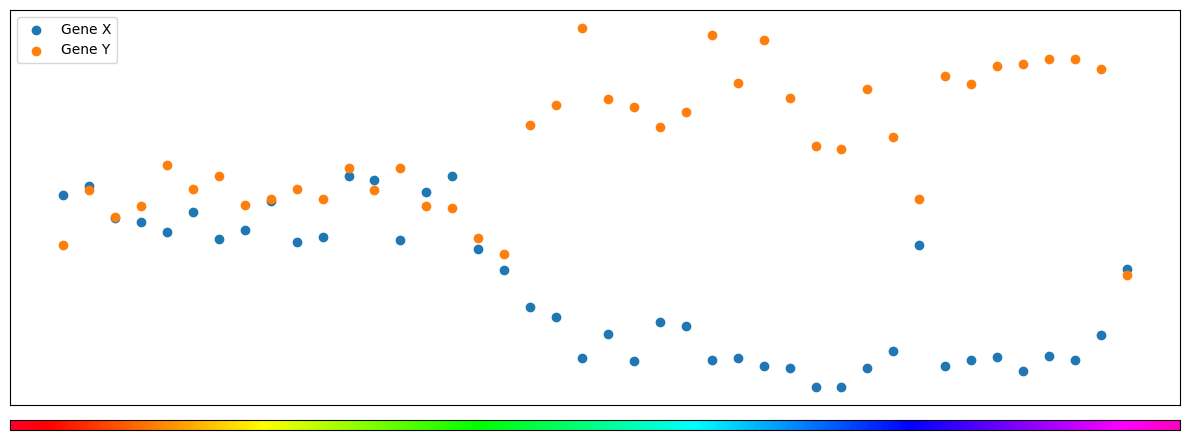

In [10]:
counts = pd.read_csv('colon/colon_CD_A_counts.csv')
cbar_rel = 0.025
fig, (ax, cax) = plt.subplots(2, 1, height_ratios=[1-cbar_rel, cbar_rel], figsize=(12, 4.5))

xs = np.arange(len(counts))

ax.scatter(xs, counts['EPCAM'], label='Gene X')
ax.scatter(xs, counts['ACTA2'], label='Gene Y')
ax.set_xticks([])
ax.set_yticks([])

cmap = colormaps['gist_rainbow']
sm = ScalarMappable(norm=Normalize(vmin=0, vmax=len(counts) - 1), cmap=cmap)
fig.colorbar(sm, cax, orientation="horizontal")

cax.set_xticks([])
cax.set_yticks([])

ax.legend()

fig.tight_layout()

fig.savefig('figs/fig0-traj.png')
fig.savefig('figs/fig0-traj.pdf')